#### Summary

Signal-generated noise becomes more problematic when all of the sources and receivers are placed in a similar region ([see this paper by Zeng and Romanowicz](https://academic.oup.com/gji/article/191/3/1361/562487)).  Here I use cluster analysis to group traces based on source-receiver locations and I stack the data in each cluster.  A final stack is made at the bottom of this notebook that shows the mean of all clusters.  This stack only shows clear signal at 410 km---a global discontinuity.

It might be worth using a similar technique in areas that are well sampled by multiple clusters?

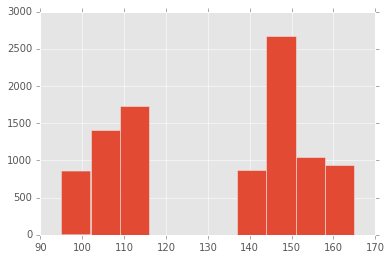

In [305]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
conn = sqlite3.connect("ss.db")
cur  = conn.cursor()

import time
import os

import pandas as pd

qry = """SELECT
bin_contents.BinNumber,
bin_contents.ID_Full,
bouncepoints_full.Event,
bouncepoints_full.Range,
bouncepoints_full.EvtDep,
bouncepoints_full.EvtTime,
bouncepoints_full.Azimuth,
bouncepoints_full.MidLat,
bouncepoints_full.MidLon,
bouncepoints_full.EvtLat,
bouncepoints_full.EvtLon,
bouncepoints_full.StaLat,
bouncepoints_full.StaLon,
snr.SNR
FROM bin_contents
LEFT JOIN bouncepoints_full 
ON bouncepoints_full.ID_Full=bin_contents.ID_Full
LEFT JOIN snr
ON bouncepoints_full.ID_Full=snr.ID_Full
WHERE bouncepoints_full.EvtDep < 75
AND ((bouncepoints_full.Range > 95
AND bouncepoints_full.Range < 115)
OR (bouncepoints_full.Range > 140
AND bouncepoints_full.Range < 165))
AND snr.SNR >= 3.0
ORDER BY bouncepoints_full.EvtDep
"""

dfds = pd.read_sql_query(qry, conn)

from matplotlib import pylab as plt
%matplotlib inline
dfbins = pd.read_sql_query("SELECT * from bin_parameters", conn)
dfds.Range.hist()

In [306]:
import pickle
file=open('migrator.pickle','rb')
f = pickle.load(file)
file.close()

In [307]:
from sklearn.cluster import KMeans
from numpy import array

X = array( [ dfds.StaLat.tolist(), dfds.StaLon.tolist(), dfds.EvtLat.tolist(), dfds.EvtLon.tolist() ] ).T

nclusters = 50

km = KMeans(n_clusters=nclusters, random_state=50).fit(X)

dfds["ClusterLabel"] = km.labels_

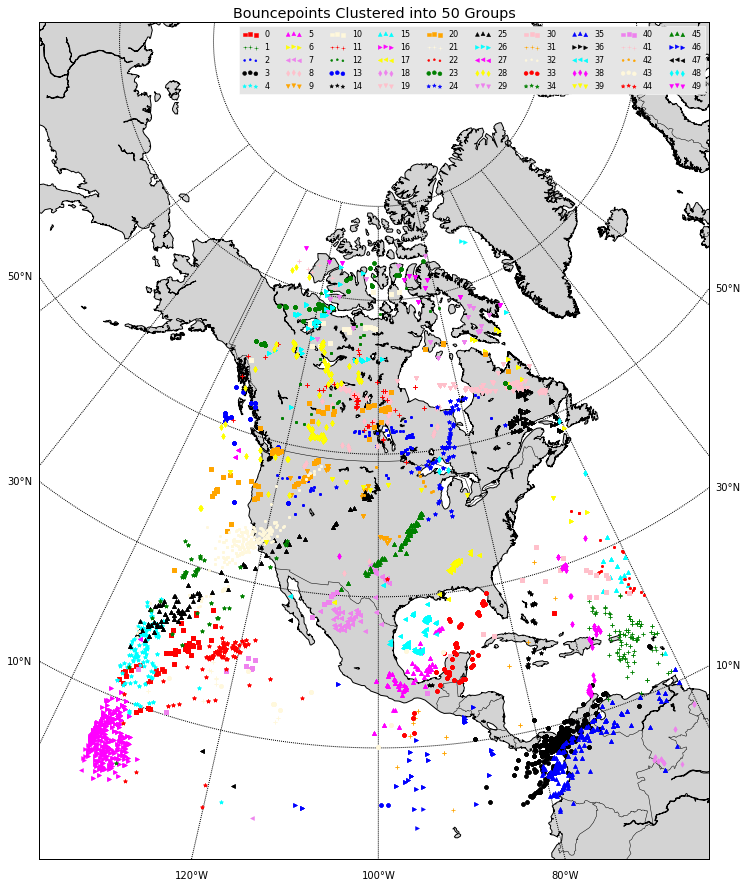

In [317]:
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*','^','>','<','d','v'))
color  = itertools.cycle(('r', 'g', 'b', 'k','cyan','magenta','yellow','violet','pink','orange','cornsilk'))

_ = plt.figure(1,figsize=(15,15))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Lambert Conformal Conic map.
m = Basemap(llcrnrlon=-135.,llcrnrlat=-10.,urcrnrlon=45.,urcrnrlat=61.,
            projection='lcc',lat_1=35.,lat_2=45.,lon_0=-100.,
            resolution ='l',area_thresh=1000.)
names = []

# draw coastlines, meridians and parallels.
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='lightgray',lake_color='white')
m.drawparallels(np.arange(10,71,20),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180,0,20),labels=[0,0,0,1])

for cluster in range(nclusters):
    dftmp = dfds.query("ClusterLabel == %s" % cluster)

    x, y = m( np.array(dftmp.MidLon.tolist()), np.array(dftmp.MidLat.tolist()) )

    _ = m.scatter(x, y, color=next(color), marker = next(marker), s=15, zorder = 9999, label = cluster)

_ = plt.title('Bouncepoints Clustered into %s Groups' % nclusters)
_ = plt.legend(fontsize=8, ncol=10)

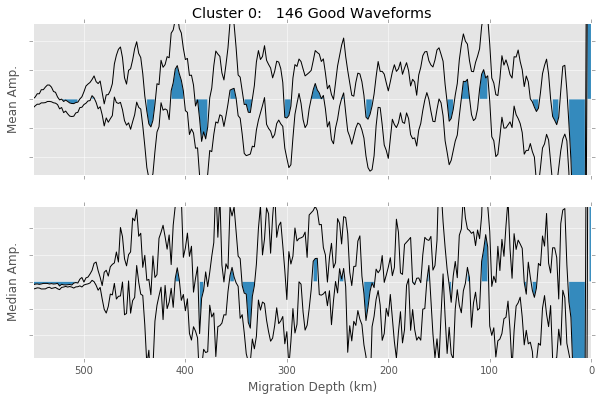

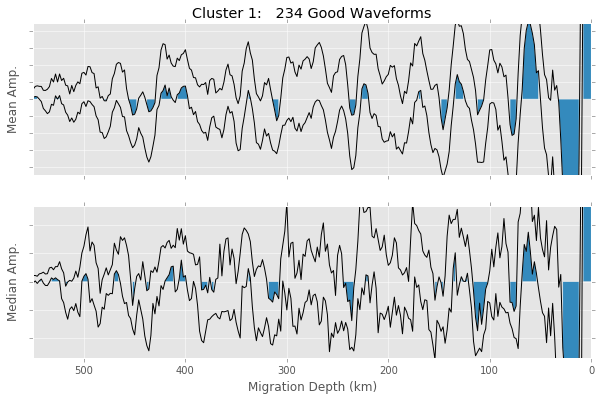

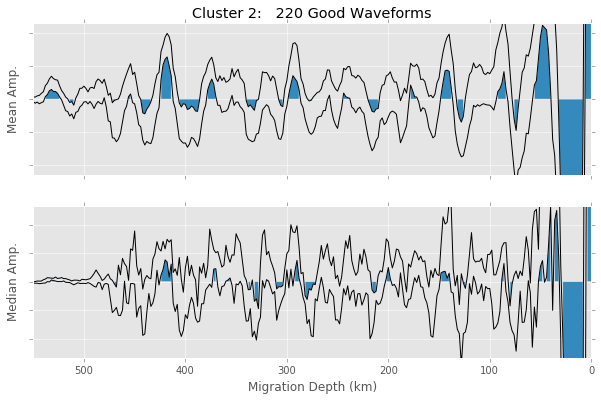

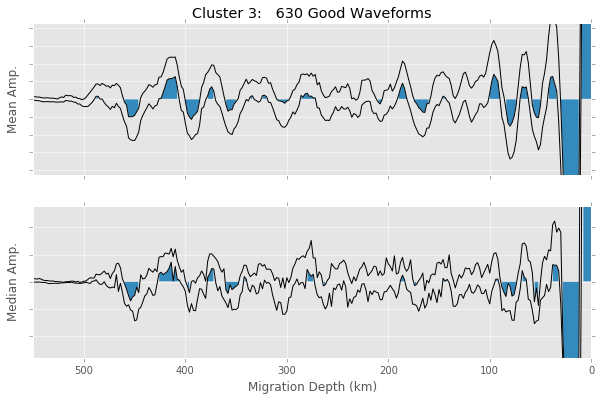

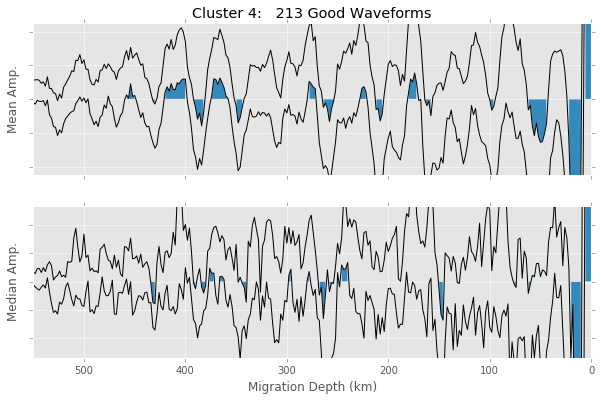

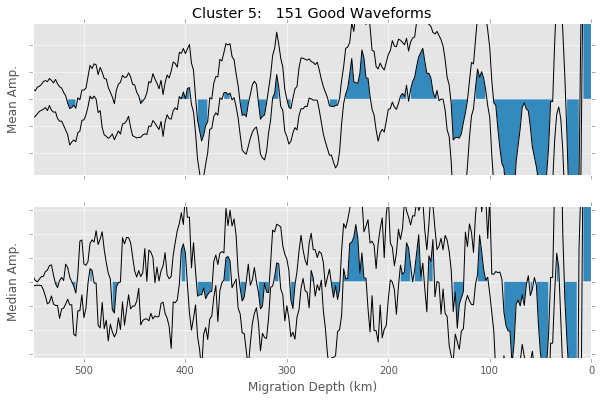

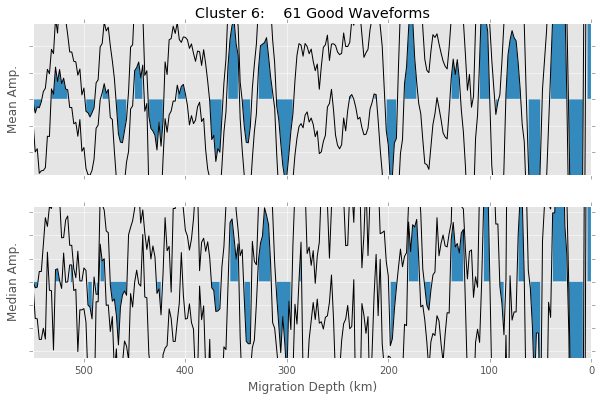

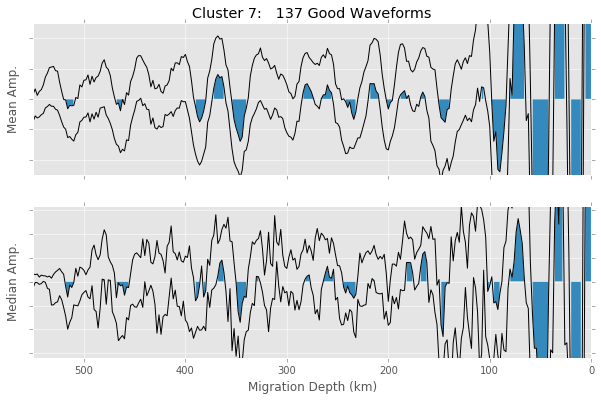

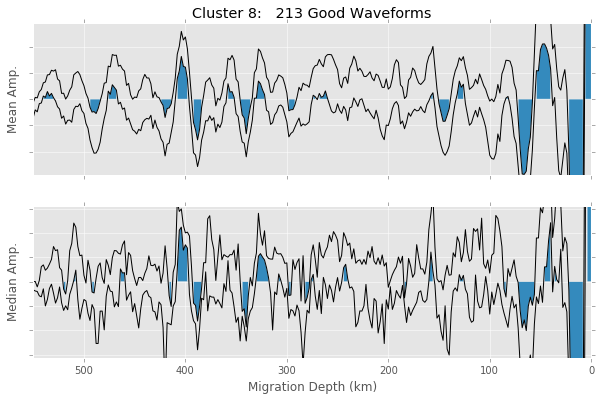

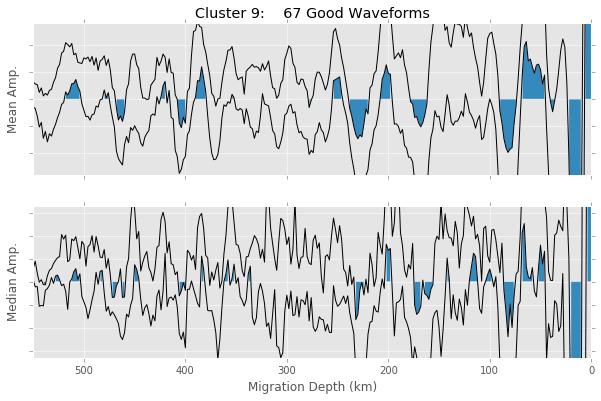

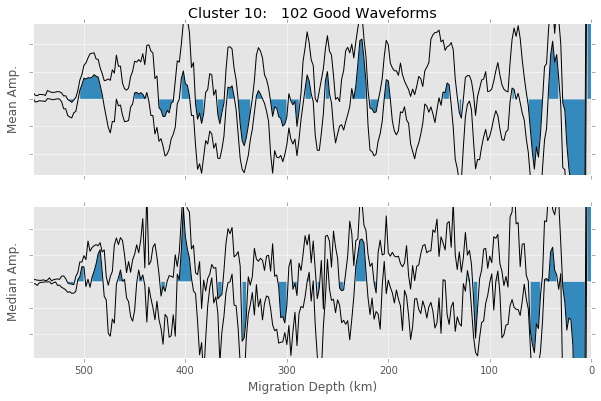

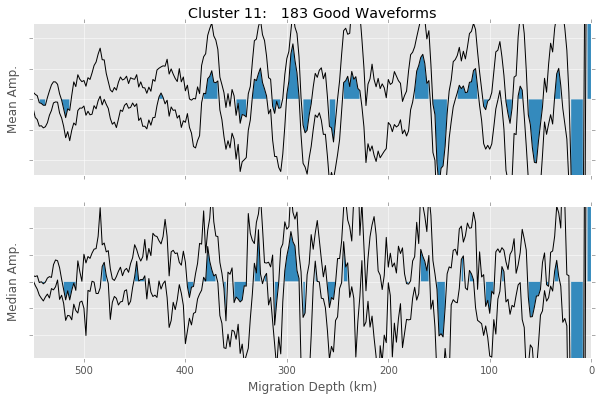

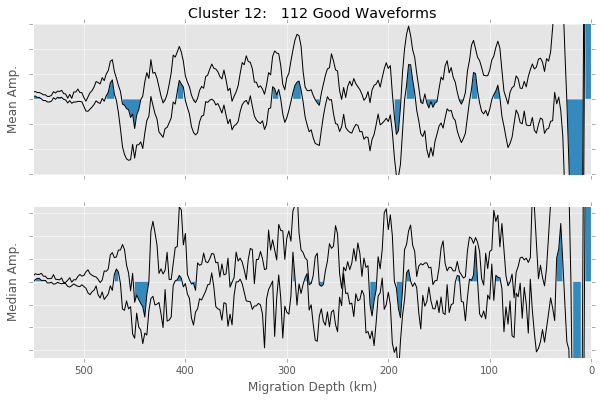

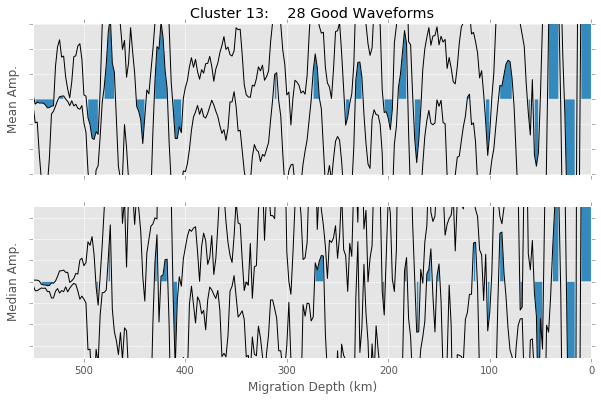

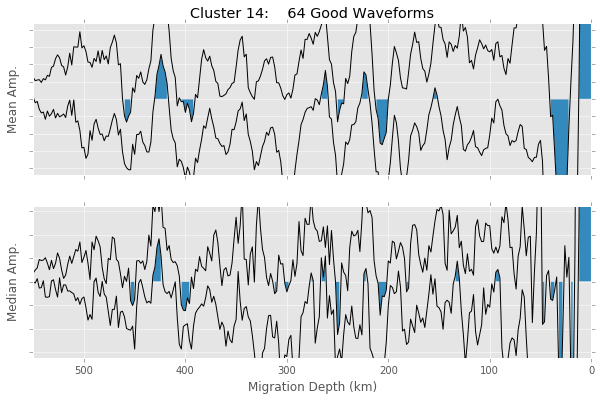

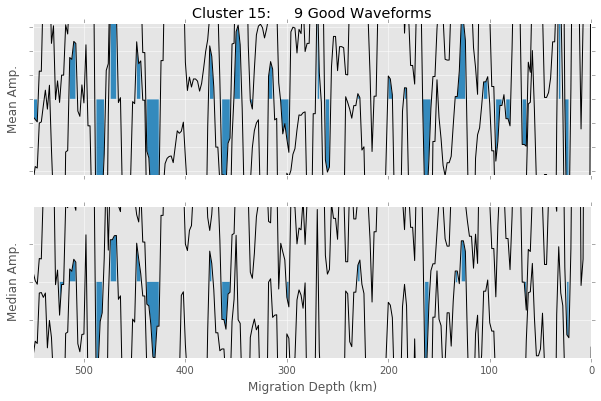

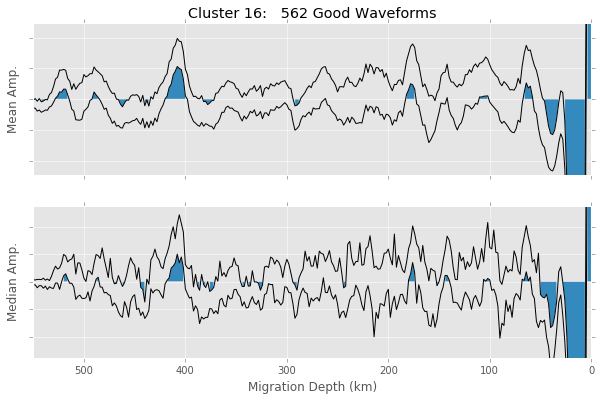

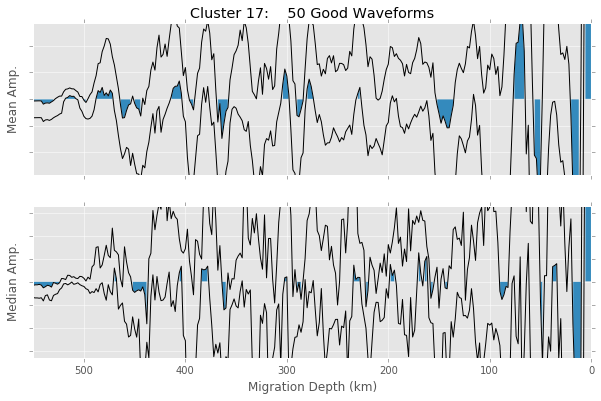

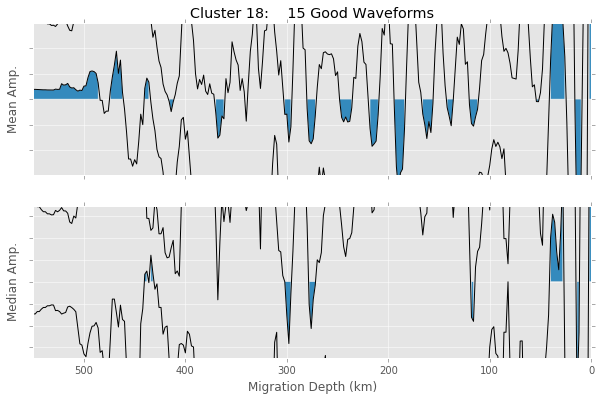

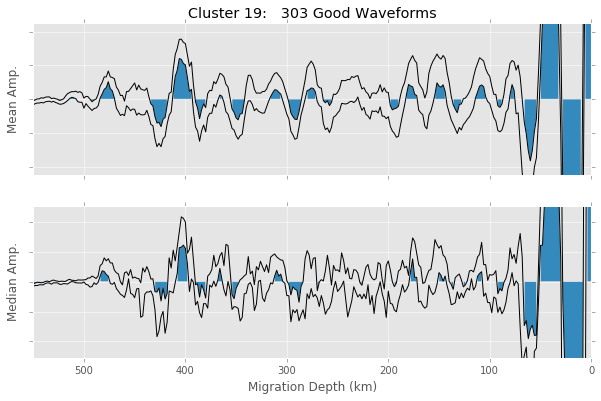

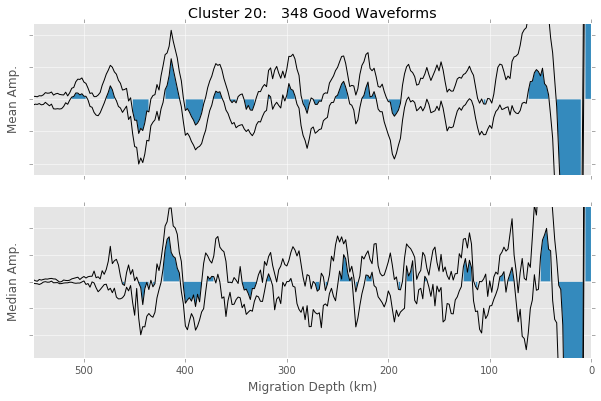

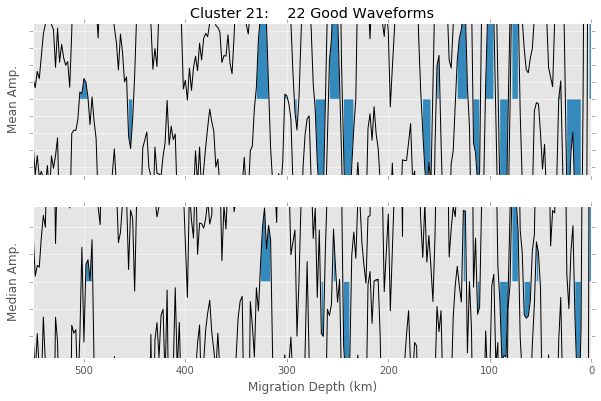

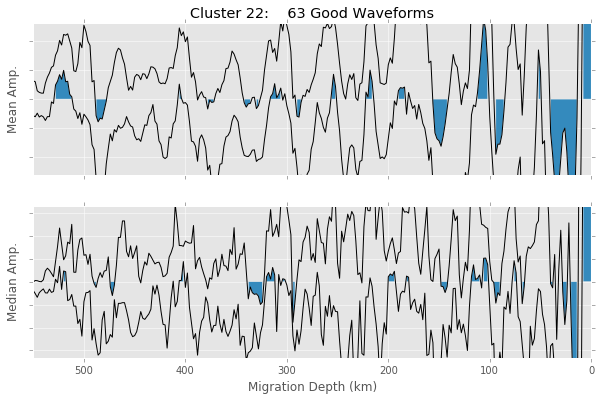

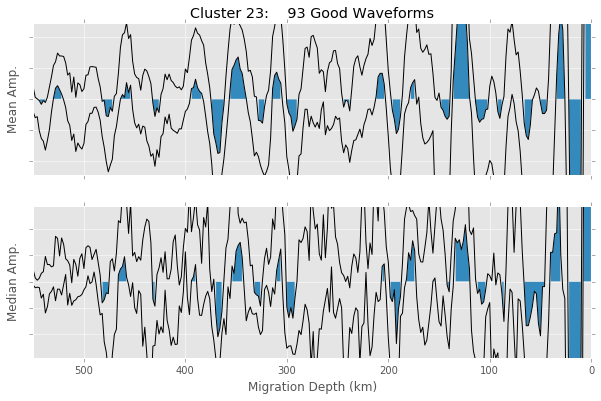

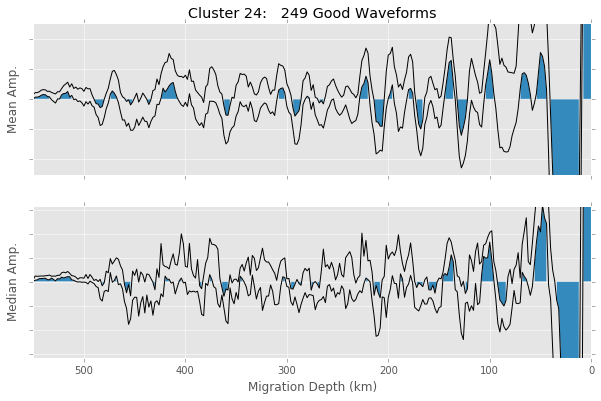

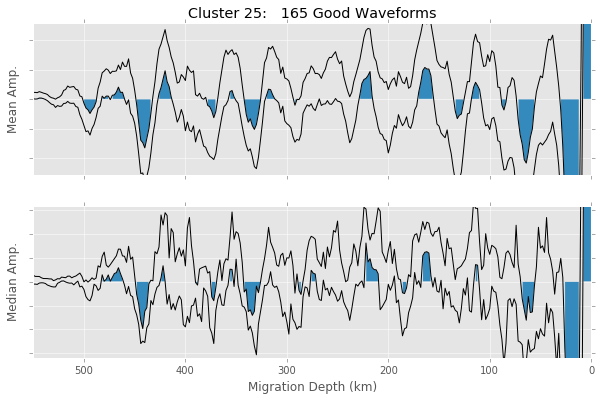

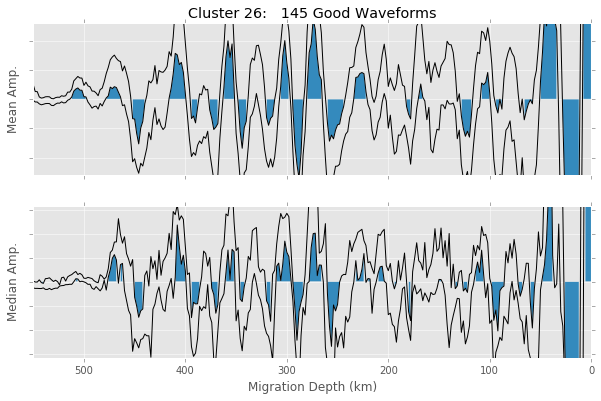

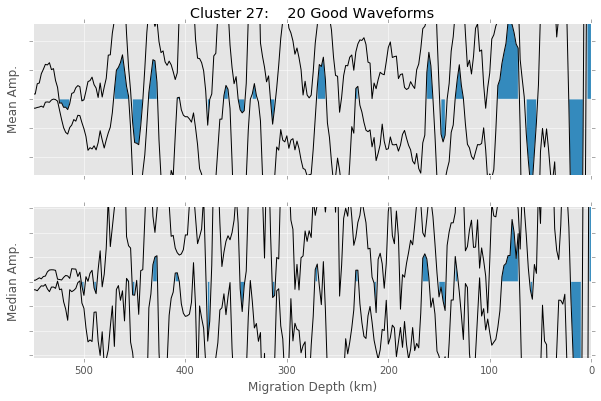

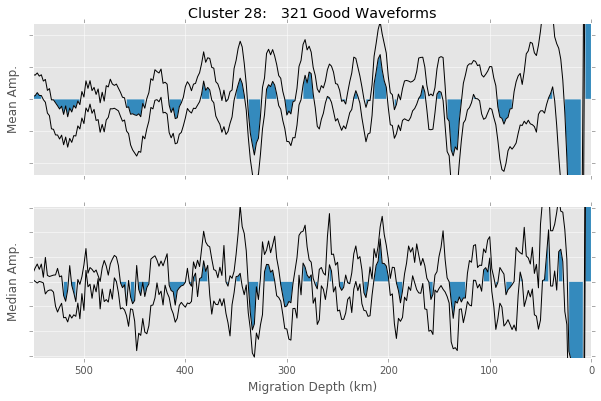

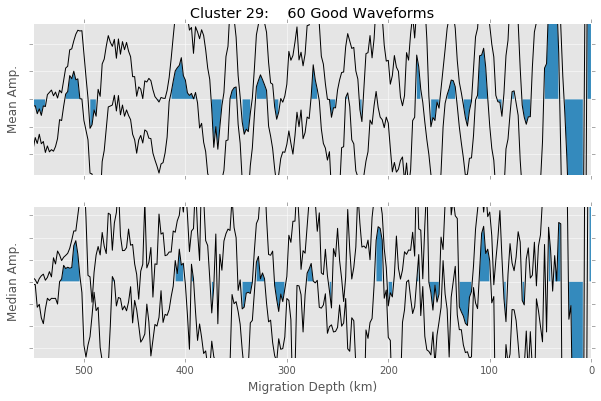

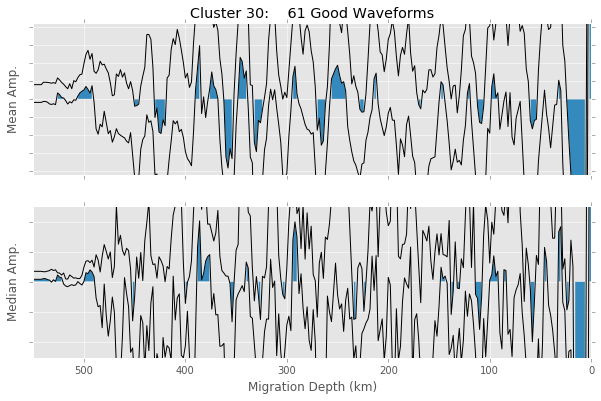

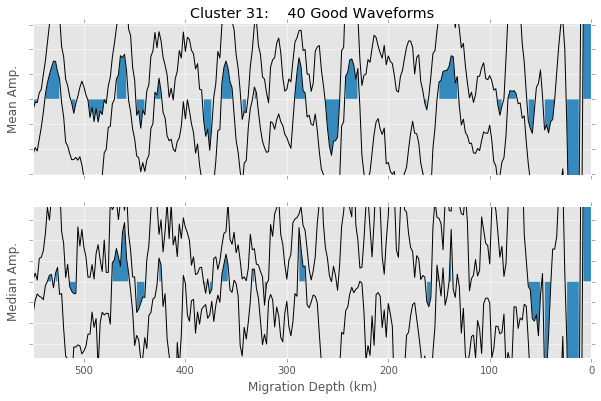

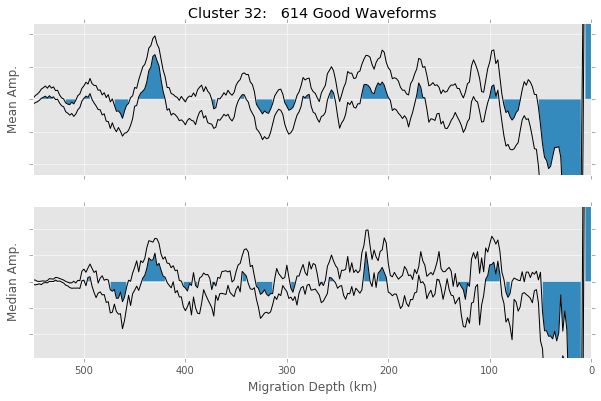

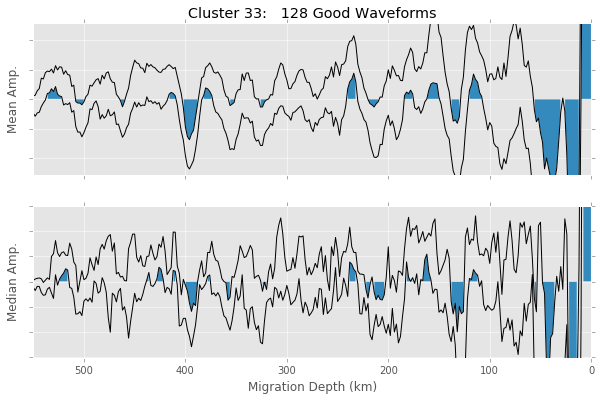

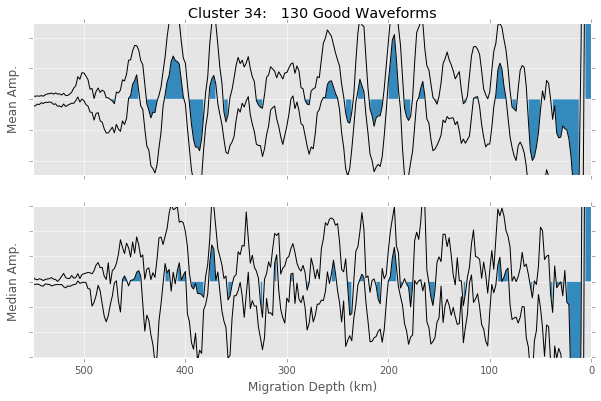

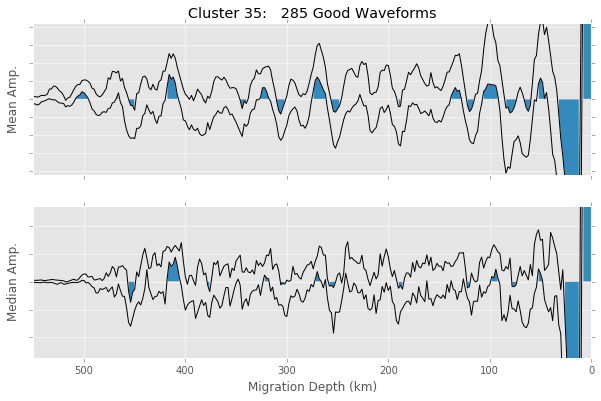

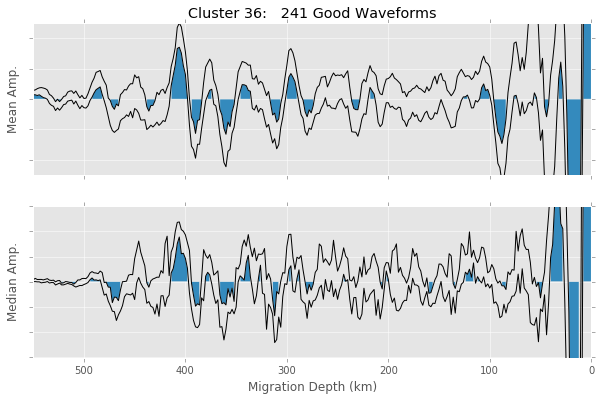

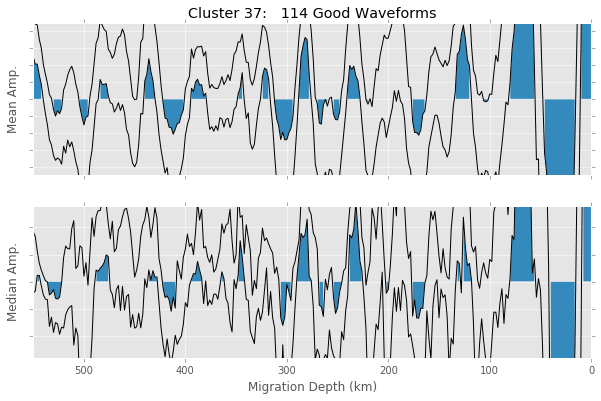

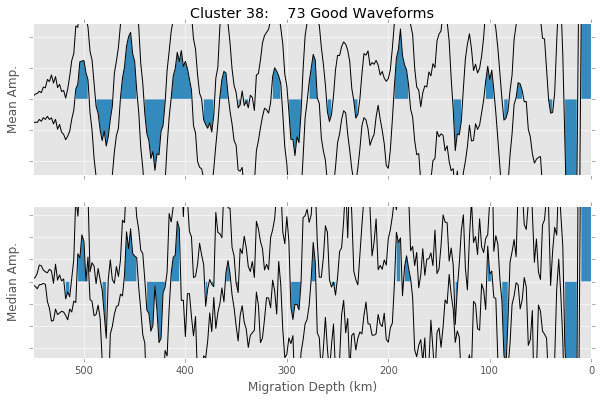

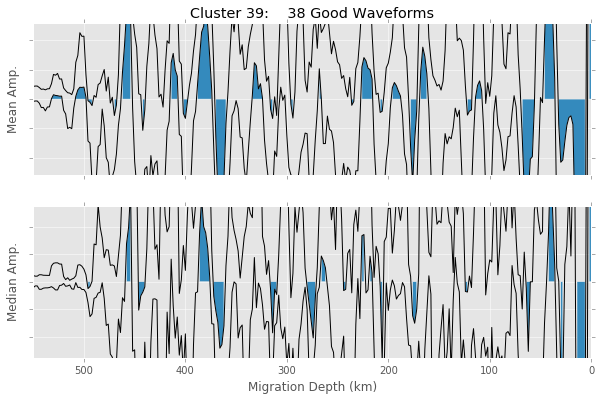

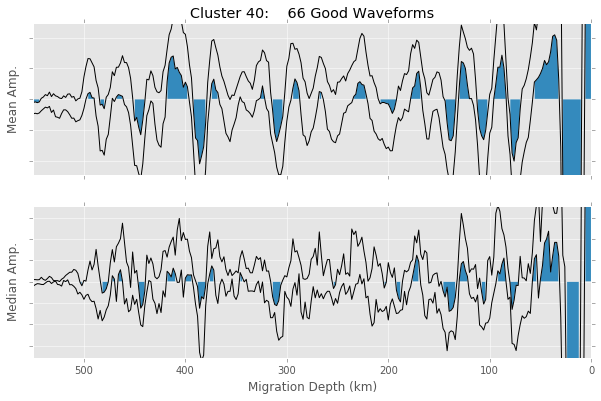

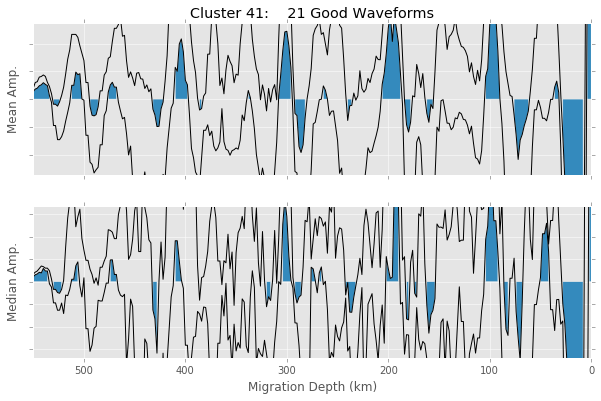

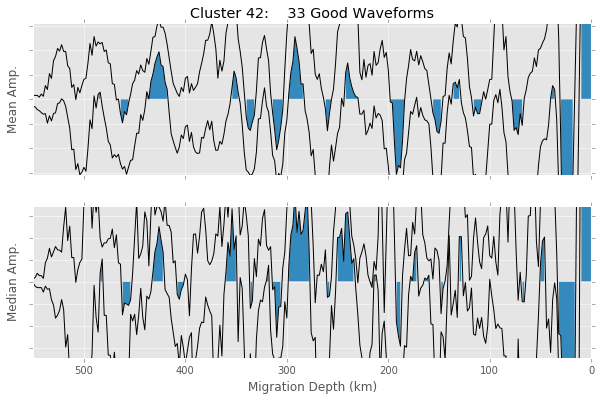

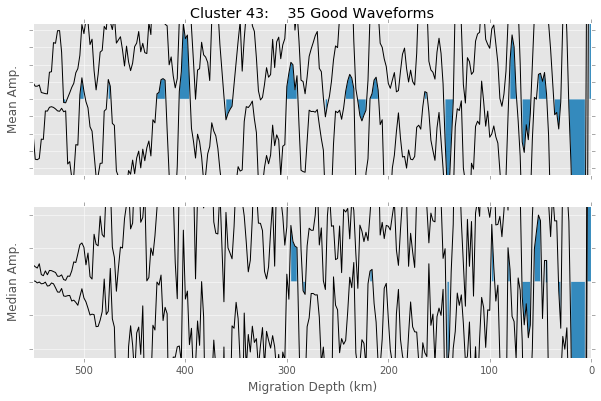

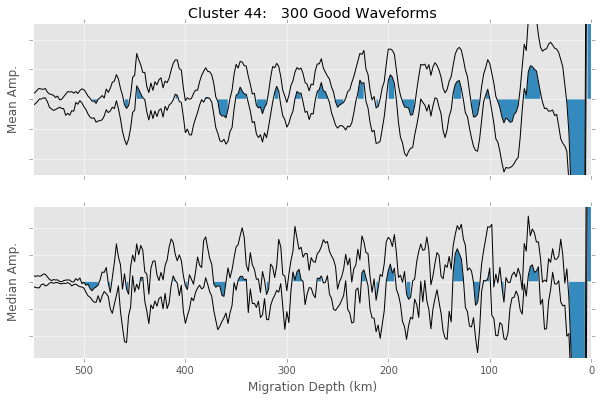

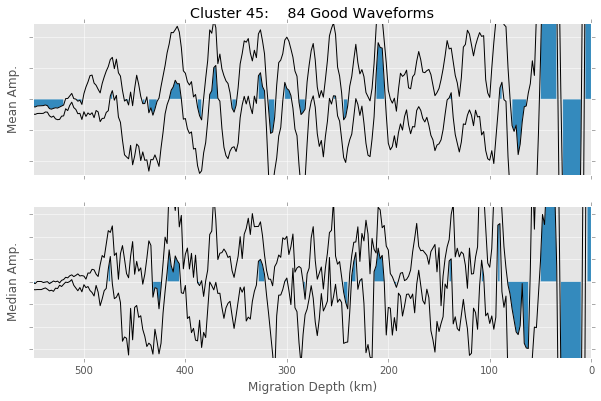

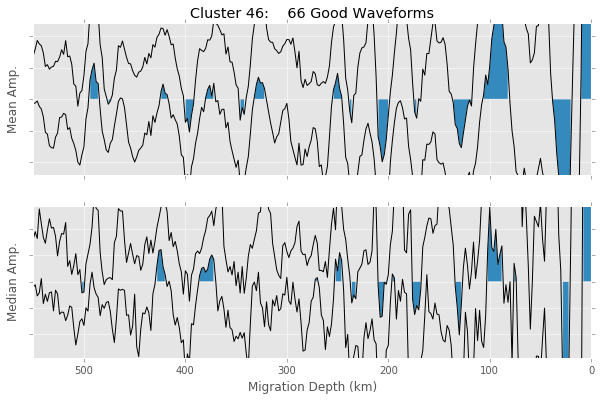

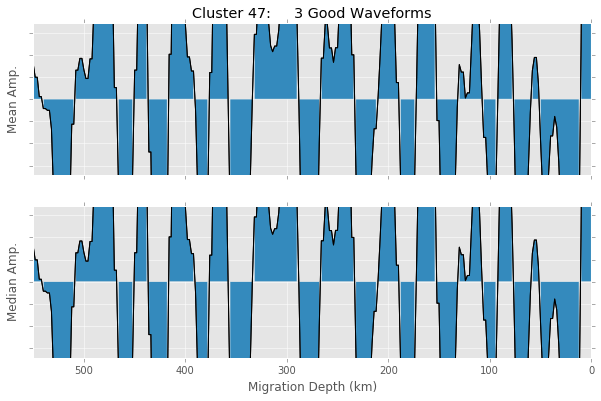

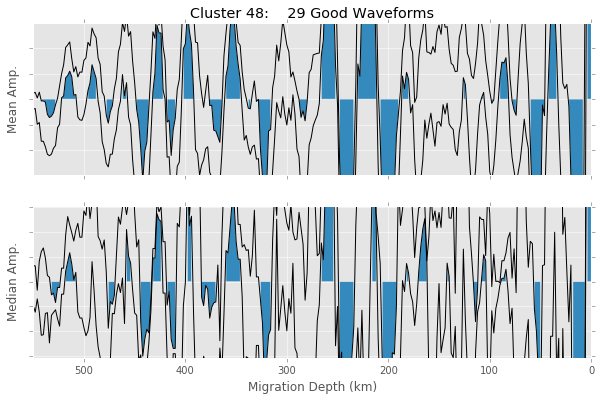

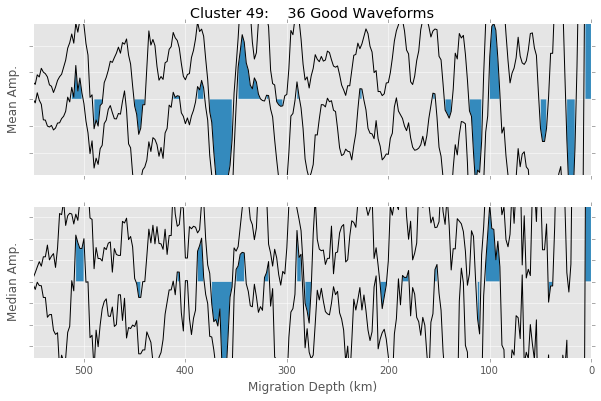

In [309]:
import obspy
from matplotlib import pylab as plt
from numpy import zeros, argmax, nan, sign, arange
from obspy.signal.filter import envelope
from scipy.signal import hilbert

from numpy import nanmean, nanmedian, nanstd, nanmin, nanmax
from numpy.random import choice


sbin = zeros(ndeps*nclusters).reshape(ndeps,nclusters) + nan
wbin = sbin.copy()

depths = range(0,552,2)

npts = 800

ndeps = len(depths)

for cluster in range(nclusters):

    dfbin = dfds.query("ClusterLabel == %s" % cluster)

    st = obspy.Stream()

    ngood = 0

    rbin = zeros(ndeps*len(dfbin)).reshape(ndeps,len(dfbin)) + nan

    for ii, row in enumerate(dfbin.iterrows()):
        bpindex = row[1].ID_Full
        directory = 'data/mseed/%s/' % row[1].Event
        filename = directory + bpindex + '.mseed'
        st0 = obspy.read(filename).detrend('linear').taper(0.05)
        #st0.filter('bandpass',freqmin=0.01,freqmax=0.1,corners=4)
        st0.filter('lowpass',freq=1./10.,corners=4,zerophase=False)
        #st0.filter('bandpass',freqmax=1./10., freqmin=1./50., corners=4,zerophase=False)
        tr = st0[0]
        tr.data = hilbert(tr.data).imag
        imax = argmax(abs(envelope(tr.data)))
        norm = sign(tr.data[imax])*envelope(tr.data)[imax]
        if imax < 195 or imax > 240:
            shifts[bpindex]  =  imax
            quality[bpindex] = 'bad'
            continue
        else:
            shifts[bpindex]  =  imax
            quality[bpindex] = 'good'
            ngood += 1

        tlist = f(row[1].Range,depths)
        ilist = []
        for each in tlist:
            tmp = int(each) + imax
            if tmp >= 0:
                pass
            else:
                tmp = 0
            ilist.append(tmp)
        tmp        = tr.data/norm  
        #tmp        = hilbert(-tr.data).imag/norm  #This is Nick Schmerr's way
        rbin[:,ii] = tmp[ilist]

    fig = plt.figure(1,figsize=(10,6))


    nboot = 30
    bbin = zeros(ndeps*nboot*2).reshape(ndeps,nboot,2) + nan

    for iboot in range(nboot):
        random_sample = choice(range(len(dfbin)), size = len(dfbin))
        bbin[:,iboot,0] = nanmean(  rbin[:,random_sample],axis=1)
        bbin[:,iboot,1] = nanmedian(rbin[:,random_sample],axis=1)

    for itype in [0,1]:
        ax = plt.subplot(2,1,itype+1)

        #plt.fill([-60,-60,-20,-20], [-2,2,2,-2], 'r', alpha=0.2, edgecolor='k')
        #plt.fill([-175,-175,-140,-140], [-2,2,2,-2], 'b', alpha=0.2, edgecolor='k')
        #plt.fill([-100,-100,-70,-70], [-2,2,2,-2], 'b', alpha=0.2, edgecolor='k')

        fmin=nanmean(bbin[:,:,itype],axis=1)-2.*nanstd(bbin[:,:,itype],axis=1)
        fmax=nanmean(bbin[:,:,itype],axis=1)+2.*nanstd(bbin[:,:,itype],axis=1)

        times = arange(len(fmin))*tr.stats.delta-npts/2

        #plt.plot(nanmean(bbin,axis=1))
        plt.plot(depths,fmax,'k')
        plt.plot(depths,fmin,'k')
        plt.fill_between(depths,0,fmin, where=fmin>0)
        plt.fill_between(depths,fmax,0, where=fmax<0)

        zoom_factor = 15.
        buf=1.04/zoom_factor

        plt.ylim(-nanmax(fmax)*buf,nanmax(fmax)*buf)
        plt.xlim(550,0)
        plt.gca().set_yticklabels([])

        if itype == 0:
            plt.title('Cluster %s: %5d Good Waveforms' % (cluster, ngood))
            plt.gca().set_xticklabels([])
            plt.ylabel('Mean Amp.')
        else:
            plt.xlabel('Migration Depth (km)')
            plt.ylabel('Median Amp.')

    sbin[:,cluster] = nanmean(bbin[:,:,itype],axis=1)
    wbin[:,cluster] = ngood
    plt.show()

(-0.05, 0.05)

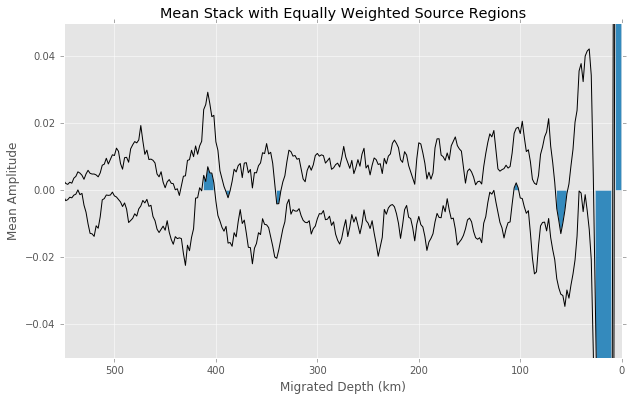

In [316]:
nboot = 100
bbin = zeros(ndeps*nboot*2).reshape(ndeps,nboot,2) + nan

for iboot in range(nboot):
    random_sample = choice(range(nclusters), size = nclusters)
    tmp = sbin[:,random_sample] #* wbin[:,random_sample]
    #tmp = tmp / wbin[0,random_sample]
    bbin[:,iboot,0] = nanmean(  tmp,axis=1)
    bbin[:,iboot,1] = nanmedian(tmp,axis=1)
    
itype = 0
    
fmin=nanmean(bbin[:,:,itype],axis=1)-2.*nanstd(bbin[:,:,itype],axis=1)
fmax=nanmean(bbin[:,:,itype],axis=1)+2.*nanstd(bbin[:,:,itype],axis=1)

fig = plt.figure(1,figsize=(10,6))
plt.plot(depths,fmax,'k')
plt.plot(depths,fmin,'k')
plt.fill_between(depths,0,fmin, where=fmin>0)
plt.fill_between(depths,fmax,0, where=fmax<0)


plt.title('Mean Stack with Equally Weighted Source Regions')
plt.ylabel('Mean Amplitude')
plt.xlabel('Migrated Depth (km)')
plt.xlim(550,0)
plt.ylim(-0.05,0.05)